See the [DataFlows documentation](https://github.com/datahq/dataflows) for more details regarding the Flow object and processing functions.

Problematics:
19 - no items
16 - too much items in csv

## Inspect the datapackages which will be loaded

Last command's output log should contain urls to datapackage.json files, open them and check the table schema to see the resource metadata and available fields which you can use in the processing functions.

Check the [frictionlessdata docs](https://frictionlessdata.io/docs/) for more details about the datapackage file format.

# Topics discussed in the knesset committees over the years.

In [ ]:
from collections import defaultdict
from dataflows import Flow
import pandas as pd
import numpy as np
import seaborn

In [494]:
# Limit processing of protocol parts for development, -1 means no limit.
PROCESS_PARTS_LIMIT = -1

# Knesset num to query
KNESSET_NUM = 16

# Enable caching of protocol parts data (not efficient, should only be used for local development with sensible PROCESS_PARTS_LIMIT)
PROCESS_PARTS_CACHE = True

# Filter the meetings to be processed, these kwargs are passed along to DataFlows filter_rows processor for meetings resource
MEETINGS_FILTER_ROWS_KWARGS = {'equals': [{'KnessetNum': KNESSET_NUM}]}

# Don'e use local data - loads everything from knesset data remote storage
# When set to False - also enables caching, so you won't download from remote storage on 2nd run.
USE_DATA = False
USE_CACHE = not USE_DATA

## Create file to save the extracted data insights

In [495]:
outfile = open("meetings_topics_knesset_" + str(KNESSET_NUM) + ".csv", 'w')
outfile.write(",".join([
    'KnessetNum',
    'Year',
    'Month',
    'Day',
    'Diplomacy_score',
    'Ecologics_score',
    'Economics_score',
    'Education_score',
    'Health_score',
    'Security_score',
    'CommitteeSessionID',
    'Number',
    'Mks',
    'Topics',
    'CommitteeID']) + "\n")                       
                         

167

## Loading lexicons

In [496]:
import os

def read_topic_to_set(topic_name):
    lines = open(os.path.join(dir_name, topic_name + ".txt"), 'r').readlines()
    return set([line.strip().replace("\ufeff", "") for line in lines])

dir_name = "../topics/lexicons"        

files = os.listdir(dir_name)

topics = [file.split('.')[0] for file in files]

lexicons = {}
for topic_name in topics:
    lexicons[topic_name] = read_topic_to_set(topic_name)
    
print(topics)

['Diplomacy', 'Ecologics', 'Economics', 'Education', 'Health', 'Security']


## Load source data

In [497]:
from dataflows import filter_rows, cache
from datapackage_pipelines_knesset.common_flow import load_knesset_data, load_member_names

# Loads a dict containing mapping between knesset member id and the member name
member_names = load_member_names(use_data=USE_DATA)

# define flow steps for loading the source committee meetings data
# the actual loading is done later in the Flow
load_steps = (
    load_knesset_data('people/committees/meeting-attendees/datapackage.json', USE_DATA),
    filter_rows(**MEETINGS_FILTER_ROWS_KWARGS)
)

if USE_CACHE:
    # when loading from URL - enable caching which will skip loading on 2nd run
    path = '.cache/people-committee-meeting-attendees-knesset-{}'.format(KNESSET_NUM)
    load_steps = (cache(*load_steps, cache_path=path),)

loading from url: https://storage.googleapis.com/knesset-data-pipelines/data/members/mk_individual/datapackage.json
using cache data from .cache/members-mk-individual-names
loading from url: https://storage.googleapis.com/knesset-data-pipelines/data/people/committees/meeting-attendees/datapackage.json


## Globals

In [498]:
running_index = 0

meeting_data_global = None
#topics_df = None
#rows = []

words_freq = defaultdict(int)
stats = defaultdict(int)
stats['processed parts'] = 0
member_attended_meetings = defaultdict(int)

## Process row
#### Extract topics from row

In [499]:
def word_permutations(word):
    clean_word = word.strip()
    permutations = [clean_word]
    if len(word) > 1 and word.startswith('ה') or word.startswith('ב') or word.startswith('ל'):
        permutations.append(word[1:])
    return permutations


def in_lexicon(word, lexicon):
    global words_freq
    for p in word_permutations(word):
        if p in lexicon:
            words_freq[p] += 1
            return True
    return False

            
def lexicon_count(lexicon, words):
    count = 0
    for word in words:
        if in_lexicon(word, lexicon):
            count += 1
    return count   


def process_meeting_protocol_part(row):
    global meeting_data_global
    global running_index
    global stats
    stats['processed parts'] += 1
    
    if 'header' in row and row['header'] is not None:
        words = row['header'].split()
    else:
        words = []
    if 'body' in row and row['body'] is not None:
        words += row['body'].split()      
    words_size_2 = [" ".join(words[i:i+2]) for i in range(len(words) - 2)]
    words_size_3 = [" ".join(words[i:i+3]) for i in range(len(words) - 3)]
                    
    for topic_name, lexicon in lexicons.items():
        meeting_data_global[topic_name + "_score"] += lexicon_count(lexicon, words)
        meeting_data_global[topic_name + "_score"] += lexicon_count(lexicon, words_size_2)  
        meeting_data_global[topic_name + "_score"] += lexicon_count(lexicon, words_size_3)  

## Append the meeting insights to all insights

In [500]:
def write_meeting_data_to_file():
    global meeting_data_global
    #print("writing to file")
    if meeting_data_global is None:
        print("first run, meeting_data_global is none")
        return

    array_to_write = [
        meeting_data_global['KnessetNum'],
        meeting_data_global['Year'],
        meeting_data_global['Month'],
        meeting_data_global['Day'],
        meeting_data_global['Diplomacy_score'],
        meeting_data_global['Ecologics_score'],
        meeting_data_global['Economics_score'],
        meeting_data_global['Education_score'],
        meeting_data_global['Health_score'],
        meeting_data_global['Security_score'],
        meeting_data_global['CommitteeSessionID'],
        meeting_data_global['Number'],
        meeting_data_global['Mks'],
        meeting_data_global['Topics'],
        meeting_data_global['CommitteeID']
    ]
    array_to_write = [str(w).replace(",","") for w in array_to_write]
    outfile.write(",".join(array_to_write) + "\n")


            
def add_meeting_data_to_table(row):
    global topics_df
    global meeting_data_global
    #max_score = 0
    #max_lexicon = "None"
    #for lexicon_name in lexicons:
    #    score = meeting_data_global[lexicon_name+"_score"]
    #    if score > max_score:
    #        max_score = score
    #        max_lexicon = lexicon_name        
    #meeting_data_global['BestTopic'] = [max_lexicon]
    if topics_df is None:
        topics_df = pd.DataFrame(meeting_data_global)
    else:
        topics_df = topics_df.append(pd.DataFrame(meeting_data_global), ignore_index=True)



## Process meeting

In [501]:
def update_attended_mks(row):
    global member_attended_meetings
    if row['attended_mk_individual_ids']:
        for mk_id in row['attended_mk_individual_ids']:
            member_attended_meetings[mk_id] += 1

            
def update_score_with_meeting_given_topics(given_topics_string):
    topic_words = given_topics_string.split()
    topic_words_size_2 = [" ".join(topic_words[i:i+2]) for i in range(len(topic_words) - 2)]
    topic_words_size_3 = [" ".join(topic_words[i:i+3]) for i in range(len(topic_words) - 3)]
      
    for topic_name, lexicon in lexicons.items():
        count = lexicon_count(lexicon, topic_words) + lexicon_count(lexicon, topic_words_size_2) + lexicon_count(lexicon, topic_words_size_3)
        meeting_data_global[topic_name + "_score"] = count*3
    

def initialize_meeting_data_global(meeting_row):
    global meeting_data_global
    topics_exists_in_meeting_data = meeting_row['topics'] is not None
    given_topics_string = " ; ".join(meeting_row['topics']).replace(",", "").replace("\n", "") if topics_exists_in_meeting_data else ""

    meeting_data_global = {
        'KnessetNum': meeting_row['KnessetNum'],
        'Year': str(meeting_row['StartDate']).split("-")[0],
        'Month': str(meeting_row['StartDate']).split("-")[1],
        'Day': str(meeting_row['StartDate']).split("-")[2].split(' ')[0],
        'CommitteeSessionID': meeting_row['CommitteeSessionID'],
        'Number': meeting_row['Number'],
        'Mks': ';'.join([str(x) for x in meeting_row['attended_mk_individual_ids']]) if meeting_row['attended_mk_individual_ids'] is not None else "",
        'Topics': given_topics_string,
        'CommitteeID': meeting_row['CommitteeID']
    } 
    
    for topic_name in topics:
        meeting_data_global[topic_name + "_score"] = 0
    
    if topics_exists_in_meeting_data:
        update_score_with_meeting_given_topics(given_topics_string)

def process_meeting(row):
    global stats
    global meeting_data_global
    stats['total meetings'] += 1
    parts_filename = row['parts_parsed_filename']
    
    #print("PROCESS_PARTS_LIMIT: " + str(PROCESS_PARTS_LIMIT))
    #print("stats['processed parts']: " + str(stats['processed parts']))

    keep_processing = PROCESS_PARTS_LIMIT == -1 or stats['processed parts'] < PROCESS_PARTS_LIMIT
    #print("keep_processing: " + str(keep_processing))
    
    # Process meeting
    if parts_filename and keep_processing:
        
        # Add previous data to file
        write_meeting_data_to_file()
        
        # Initialize new global data to file
        initialize_meeting_data_global(row)
        
        # Count the mks that attended the meeting
        update_attended_mks(row)
        
        # load data step
        steps = (load_knesset_data('committees/meeting_protocols_parts/' + parts_filename, USE_DATA),)
        if USE_CACHE and PROCESS_PARTS_CACHE:
            steps = (cache(*steps, cache_path='.cache/committee-meeting-protocol-parts/' + parts_filename),)
            
        # Text insights step
        steps += (process_meeting_protocol_part,)
        
        # Run meeting processing steps
        Flow(*steps).process()

## Define flow

In [502]:
process_steps = (
    process_meeting,
    #add_meeting_data_to_table,
    #write_meeting_data_to_file
)

## Run flow

In [503]:
from dataflows import Flow, dump_to_path

Flow(*load_steps, *process_steps, dump_to_path('data/committee-meeting-attendees-parts')).process()

DEBUG   :Starting new HTTPS connection (1): storage.googleapis.com:443


loading fresh data, saving cache to: .cache/people-committee-meeting-attendees-knesset-4


DEBUG   :https://storage.googleapis.com:443 "GET /knesset-data-pipelines/data/people/committees/meeting-attendees/datapackage.json HTTP/1.1" 200 4330
DEBUG   :Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG   :https://storage.googleapis.com:443 "GET /knesset-data-pipelines/data/people/committees/meeting-attendees/datapackage.json HTTP/1.1" 200 4330
DEBUG   :Starting new HTTPS connection (1): storage.googleapis.com:443
DEBUG   :https://storage.googleapis.com:443 "GET /knesset-data-pipelines/data/people/committees/meeting-attendees/kns_committeesession.csv HTTP/1.1" 200 20291492
DEBUG   :Starting new HTTPS connection (2): storage.googleapis.com:443
DEBUG   :https://storage.googleapis.com:443 "GET /knesset-data-pipelines/data/people/committees/meeting-attendees/kns_committeesession.csv HTTP/1.1" 200 20291492


(<datapackage.package.Package at 0x7f9d63f4bef0>,
 {'count_of_rows': 0,
  'bytes': 9421,
  'hash': '3d802ffb932d15e4e62be7c4756eec67',
  'dataset_name': None})

In [504]:
outfile.close()

### Analyze the words that influenced the topic scores the most.
Using this we filtered the words 'כספים' and 'אוצר' from the Economics lexicon since they represent budgets more then economy discussions.

In [505]:
words = list(words_freq.keys())
freqs = list(words_freq.values())
word_freq_d = {"Lexicon words": words,
             "Frquency": freqs}
word_freq_df = pd.DataFrame(word_freq_d)
word_freq_df.to_csv("words_freq_knesset_" + str(KNESSET_NUM) + ".csv")

### Analyze the attendance of each mk (member of the knesset)

In [506]:
mks = list(member_attended_meetings.keys())
counts = list(member_attended_meetings.values())
dictionary = {"MKS": mks,
             "Attendences": counts}
attending_mks_df = pd.DataFrame(data=dictionary)
attending_mks_df.to_csv("attending_mks_knesset_" + str(KNESSET_NUM) + ".csv")

# Analyze the most common topics that appeared in the knesset committees

In [78]:
import matplotlib
def draw_knesset_topics(knesset_num):
    # Get knesset collected data
    df_knesset = pd.read_csv("meetings_topics_knesset_" + str(knesset_num) + ".csv")
    smaller_df = df_knesset[['KnessetNum', 'Year', 'Month',
                              'Diplomacy_score', 'Ecologics_score', 'Economics_score', 'Education_score',
                              'Health_score', 'Security_score']]
    
    # Normalize scores
    topics = smaller_df.apply(lambda row: normalize_scores(row[3:]), axis=1)
    topics_df = pd.DataFrame(topics)
    smaller_df[['Diplomacy_score', 'Ecologics_score', 'Economics_score', 'Education_score',
                          'Health_score', 'Security_score']] = pd.DataFrame(topics_df[0].values.tolist(), index= topics_df.index)
    smaller_df['Year.Month'] = smaller_df['Year'] + (smaller_df['Month'] -1)/12.0
    
    # Aggredate per month and year
    by_month = smaller_df.groupby(['Year.Month']).mean()
    
    # Plot topics graph
    by_month.plot(y=['Diplomacy_score', 'Ecologics_score', 'Economics_score',
                     'Education_score', 'Health_score', 'Security_score'], 
                  title="Knesset " + str(knesset_num) + " - Most popular topics over time",
                 figsize=(10,5))

### Normalize the topics' scores

In [79]:
def normalize_scores(scores):
    max_i = (0, -1)
    second_i = (0, -1)
    third_i = (0, -1)
    for i in range(len(scores)):
        if scores[i] != 0:
            if scores[i] > max_i[0]:
                third_i = second_i
                second_i = max_i
                max_i = (scores[i], i)
            elif scores[i] > second_i[0]:
                third_i = second_i
                second_i = (scores[i], i)
            elif scores[i] > third_i[0]:
                third_i = (scores[i], i)
        
    scores = [0] * len(scores)
    if max_i[1] != -1:
        scores[max_i[1]] = 3
    if second_i[1] != -1:
        scores[second_i[1]] = 2
    if  third_i[1] != -1:
        scores[third_i[1]] = 1
    return scores

## Explaining the results: 
## the lexicon words that appears the most in the knesset

In [101]:
import csv
from wordcloud import WordCloud

def get_and_flip_freq_dictionary_for_knesset(knesset_num):
    freq_dictionary = dict()
    with open("words_freq_knesset_" + str(knesset_num) + ".csv", 'r', encoding="utf-8") as csvFile:
        reader = csv.reader(csvFile)
        first = True
        for row in reader:
            if first:
                first = False
                continue
            # we flip the word since it's in hebrew and not supported
            flipped_word = ''.join(reversed(row[1]))
            freq_dictionary[flipped_word] = int(row[2])
    return freq_dictionary

def draw_lexicon_word_cloud_per_knesset(knesset_num):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                min_font_size = 10,
                font_path='C:/Windows/Fonts/Gisha.ttf')
    
    freq_dictionary = get_and_flip_freq_dictionary_for_knesset(knesset_num)
    wordcloud.generate_from_frequencies(frequencies=freq_dictionary, )
    matplotlib.pyplot.figure(figsize = (8, 8), facecolor = None)
    matplotlib.pyplot.imshow(wordcloud)

# Time for some cool graphs!

C:\ProgramData\Anaconda3\envs\python36venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


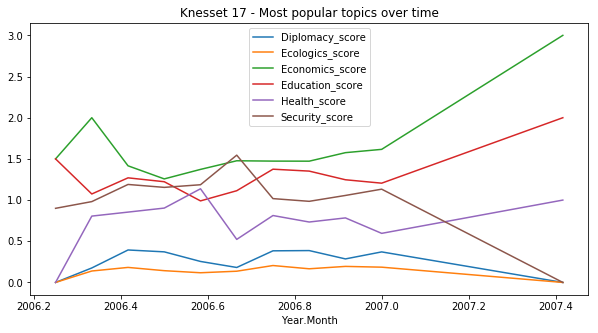

In [82]:
draw_knesset_topics(17)

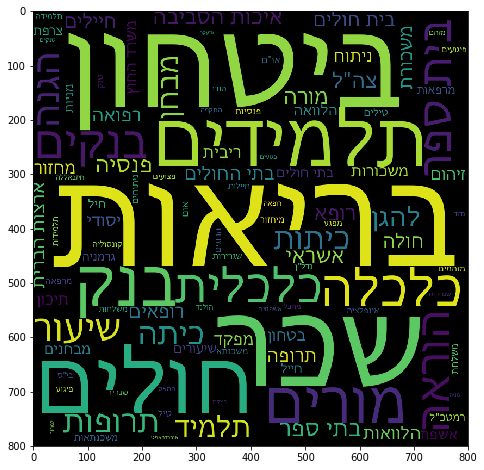

In [102]:
draw_lexicon_word_cloud_per_knesset(17)

C:\ProgramData\Anaconda3\envs\python36venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


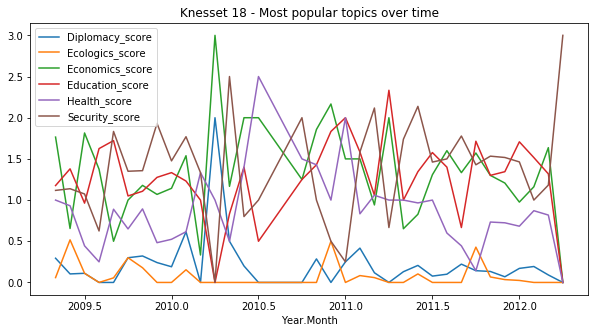

In [81]:
draw_knesset_topics(18)

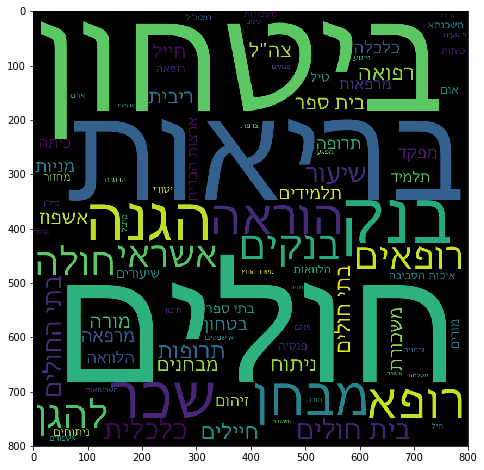

In [103]:
draw_lexicon_word_cloud_per_knesset(18)

C:\ProgramData\Anaconda3\envs\python36venv\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\ProgramData\Anaconda3\envs\python36venv\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


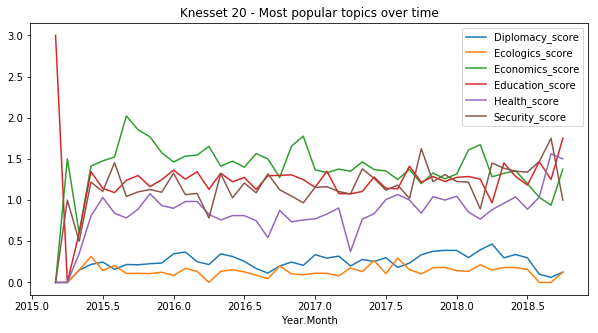

In [80]:
draw_knesset_topics(20)

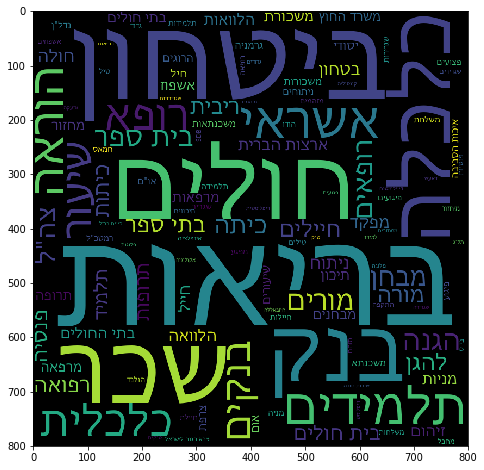

In [104]:
draw_lexicon_word_cloud_per_knesset(20)

In [507]:
#attending_mks_df
#attending_mks_df

In [508]:
#with open("rows.txt", 'w') as r:
#    r.write(str(rows))

In [509]:
#rows[:3]

In [510]:
#topics_df.to_csv("topics_df_knesset_{}.csv".format(KNESSET_NUM))

In [511]:
#df_summary = topics_df

In [512]:
#df_summary['BestTopic'] = df[['Diplomacy_score', 'Ecologics_score', 'Economics_score','Education_score', 'Health_score', 'Security_score']].idxmax(axis=1)

In [513]:
#df_summary.to_csv("topics_df_knesset_{}_summarized.csv".format(KNESSET_NUM))

In [514]:
#g = df[['Year', 'BestTopic']].groupby(['Year', 'BestTopic']).count()

In [515]:
#g

In [516]:
#with open("topics_output.csv", 'w') as f:
#    f.write(topics_df.to_csv())

## Aggregate and print stats

In [517]:
#from collections import deque
#import yaml

#top_attended_member_names = [member_names[mk_id] for mk_id, num_attended in
#                             deque(sorted(member_attended_meetings.items(), key=lambda kv: kv[1]), maxlen=5)]
#print('\n')
#print('-- top attended members --')
#print(top_attended_member_names)
#print('\n')
#print('-- stats --')
#print(yaml.dump(dict(stats), default_flow_style=False, allow_unicode=True))

## Get output data

Output data is available in the left sidebar under data directory, you can check the datapackage.json and created csv file to explore the data and schema.